### Setup

In [ ]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy
!pip install wandb
!pip install matplotlib

https://huggingface.co/settings/tokens

In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import PIL
from PIL import Image
from tqdm.auto import tqdm

from typing import List, Dict
import torchvision
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

from diffusers import DDPMScheduler, UNet2DModel

def show_images(x: torch.Tensor):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    
    return grid_im

def make_grid(images: PIL.Image, size=64):
    output_im = Image.new('RGB', (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    
    return output_im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset

In [ ]:
dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')
image_size = 32
batch_size = 128

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    ])

def transform(examples: Dict[str, List]):
    images = [preprocess(img.convert('RGB')) for img in examples['image']]
    
    return {'images': images}

dataset.set_transform(transform)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))['images'][:8].to(device)
batch.shape

### Scheduler

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label='% of input')
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label='% of noise')
plt.legend()
plt.show()

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label='% of input')
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label='% of noise')
plt.legend()
plt.show()

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=1e-3, beta_end=4e-3)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label='% of input')
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label='% of noise')
plt.legend()
plt.show()

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(batch)
noisy_batch = noise_scheduler.add_noise(batch, noise, timesteps).to(device)

show_images(noisy_batch).resize((8 * 128, 128))

### UNet

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'AttnDownBlock2D',
    ),
    up_block_types=(
        'AttnUpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

model = model.to(device)

In [ ]:
model.eval()
with torch.inference_mode():
    model_preds = model(sample=noisy_batch, timestep=timesteps).sample

model_preds.shape

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

model.train()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=4e-4)

losses = []

epochs = 30
for epoch in tqdm(range(epochs), desc='Training progress'):
    for step, batch in enumerate(tqdm(train_dataloader, leave=False, desc=f'Epoch {epoch+1} progress')):
        images = batch['images'].to(device)
        noise = torch.randn_like(images).to(device)
        batch_size = images.shape[0]
        
        timesteps = torch.randint(low=0, high=noise_scheduler.num_train_timesteps, size=(batch_size,), device=device).long()
        
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        
        model_preds = model(sample=noisy_images, timestep=timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(input=model_preds, target=noise)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader): ]) / len(train_dataloader)
        print(f'Epoch: {epoch+1} | Loss: {loss_last_epoch}')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### Generate images (Pipeline)

In [ ]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
pipe_output = pipeline()

In [ ]:
pipe_output.images[0]

In [ ]:
pipeline.save_pretrained('butterflies')

### Generate images (Sampling loop)

In [ ]:
sample = torch.randn(8, 3, 32, 32).to(device)
model.eval()

for i, ts in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.inference_mode():
        residual = model(sample=sample, timestep=ts).sample
    
    sample = noise_scheduler.step(residual, ts, sample).prev_sample

In [ ]:
show_images(sample)

## Pokemon

#### Dataset

In [9]:
dataset = load_dataset('matteopilotto/pokemon_cute', split='train')

Using custom data configuration matteopilotto--pokemon_cute-1151300529356769


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1453 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/matteopilotto___parquet/matteopilotto--pokemon_cute-1151300529356769/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [10]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1453
})

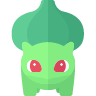

In [11]:
dataset[0]['image']

In [12]:
image_size = 64
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_fn(examples: Dict[str, List]):
    images = [preprocess(img.convert('RGB')) for img in examples['image']]
    
    return {'images': images}

dataset.set_transform(preprocess_fn)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
batch = next(iter(train_dataloader))['images']
batch.shape

torch.Size([64, 3, 64, 64])

In [14]:
tensor2pil = transforms.ToPILImage()

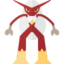

In [15]:
tensor2pil(batch[1] * 0.5 + 0.5)

#### Scheduler

In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [17]:
num_timesteps = 8
image = batch[0]
image_expanded = image.expand(num_timesteps, *image.shape)
noise = torch.randn_like(image_expanded)
timesteps = torch.linspace(0, noise_scheduler.num_train_timesteps-1, steps=num_timesteps).long()
noisy_image_expanded = noise_scheduler.add_noise(image_expanded, noise, timesteps)

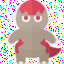

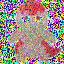

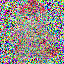

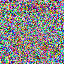

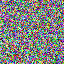

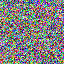

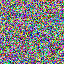

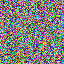

In [18]:
for i in range(8):
    display(tensor2pil(noisy_image_expanded[i] * 0.5 + 0.5))

#### UNet

In [19]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'AttnDownBlock2D',
    ),
    up_block_types=(
        'AttnUpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    )
)

model = model.to(device)

In [20]:
def init_model():
    model = UNet2DModel(
        sample_size=image_size,
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(64, 128, 128, 256),
        down_block_types=(
            'DownBlock2D',
            'DownBlock2D',
            'AttnDownBlock2D',
            'AttnDownBlock2D',
        ),
        up_block_types=(
            'AttnUpBlock2D',
            'AttnUpBlock2D',
            'UpBlock2D',
            'UpBlock2D',
        )
    )

    model = model.to(device)
    
    return model

In [21]:
import random

timesteps = torch.tensor(random.sample(range(noise_scheduler.num_train_timesteps), k=batch_size))
noise = torch.randn_like(batch)
noisy_batch = noise_scheduler.add_noise(batch, noise, timesteps)

model.eval()
with torch.inference_mode():
    model_preds = model(sample=noisy_batch.to(device), timestep=timesteps.to(device)).sample
    
model_preds.shape

torch.Size([64, 3, 64, 64])

#### Training loop

In [34]:
model = init_model()
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
optimizer = torch.optim.AdamW(params=model.parameters(), lr=4e-4)

epochs = 30
losses = []

for epoch in tqdm(range(epochs)):
    for i, batch in enumerate(tqdm(train_dataloader, leave=False)):
        images = batch['images'].to(device)
        noise = torch.randn_like(images).to(device)
        timesteps = torch.tensor(random.sample(range(noise_scheduler.num_train_timesteps), k=images.shape[0])).to(device)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        
        preds = model(noisy_images, timesteps).sample
        
        loss = F.mse_loss(preds, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().item())
    
    if (epoch+1) % 5 == 0:
        epoch_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch {epoch+1} | Loss: {epoch_loss}")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.0737423226237297


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.04628804099300633


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.035862601483645645


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.036559679423985275


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.03442447915997194


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.03318123017316279


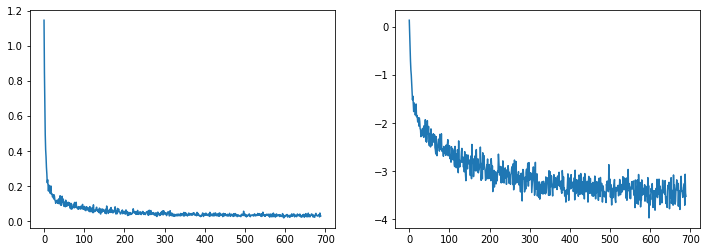

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

#### Inference

In [ ]:
sample = torch.randn(4, 3, 64, 64)
